In [ ]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = (
    f"/Users/{os.environ['USER']}/secrets/dosewise-473716-9f4874e812d6.json"
)

In [63]:
from google.cloud import storage
import pandas as pd

bucket_name = "dosewisedb"
table_prefix = "hemodyn_table/"

client = storage.Client()
bucket = client.bucket(bucket_name)

# List all blobs in the hemodyn_table directory
blobs = list(bucket.list_blobs(prefix=table_prefix))

# Filter for parquet files and sort by name (timestamps are in the path)
parquet_files = [blob.name for blob in blobs if blob.name.endswith(".parquet")]

if not parquet_files:
    raise FileNotFoundError(f"No parquet files found in {table_prefix}")

# Sort to get the latest (timestamps are chronologically sortable)
latest_file = sorted(parquet_files)[-1]

print(f"Loading latest file: {latest_file}")

# Directly read from GCS
df = pd.read_parquet(f"gs://{bucket_name}/{latest_file}")
print(f"Successfully loaded data with shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Loading latest file: hemodyn_table/2025-10-07-09-16-52/hemodyn_table.parquet
Successfully loaded data with shape: (1866721, 7)

First few rows:
    id      ART    ECG_II      PLETH  CO2  PHEN_RATE  time
0  513      NaN       NaN        NaN  NaN        NaN     1
1  513  5.01471  0.622872  30.839600  0.0        NaN     2
2  513  5.01471  0.741367  74.682701  0.0        NaN     3
3  513  5.01471  0.069896  37.554298  0.0        NaN     4
4  513  5.01471  0.198266  54.933601  0.0        NaN     5


In [64]:
ids = df["id"].unique()
ids

array([ 513, 3585, 4618,  527, 6160,   20, 5142, 6166,   28, 3107, 5670,
       4149,   61, 1094, 5204, 2134, 2147, 1133, 1647, 4729, 3711, 5760,
       2693, 6281, 4749, 6292, 3736, 5787,  163, 5302,  185, 5311, 5826,
       5827, 2765, 3277, 1745, 3800, 3803, 3293, 4317, 1759,  230,  233,
        746, 4333, 3824,  241, 4337, 5875, 6388, 5368,  252, 3840,  769,
       3843, 1799, 2824, 4871, 1803, 1297, 3857, 1814, 3357, 4388,  293,
       1320, 1849, 1341,  853, 1367, 4953, 1375, 2400,  865,  354, 4962,
        375, 5497, 5516, 1934, 1936, 1941, 6043, 5534,  936, 5043, 4024,
       4541,  451, 3538, 1492, 5593, 4072, 5608, 1004, 6124, 1520,  497,
       6131, 6134, 5626, 3582])

In [69]:
df[df["id"] == ids[1]].head(10)

,id,ART,ECG_II,PLETH,CO2,PHEN_RATE,time
12322,3585,-495.626007,-4.956260,-198.250000,0.0,0.0,12323
12323,3585,-495.626007,-4.956260,-198.250000,0.0,0.0,12324
12324,3585,-16.709299,-0.255965,49.008801,0.0,0.0,12325
12325,3585,-16.709299,-0.463331,32.419601,0.0,0.0,12326
12326,3585,-16.709299,-0.038724,48.613899,0.0,0.0,12327
12327,3585,-16.709299,-0.334961,33.209499,0.0,0.0,12328
12328,3585,-16.709299,-0.374459,27.679800,0.0,0.0,12329
12329,3585,-16.709299,-0.631198,47.033901,0.0,0.0,12330
12330,3585,-16.709299,-0.631198,31.234600,0.0,0.0,12331
12331,3585,-16.709299,-0.641073,31.234600,0.0,0.0,12332


In [65]:
# Missing data imputation
df["ART"] = df.groupby("id")["ART"].transform(lambda x: x.ffill().bfill())
df["ECG_II"] = df.groupby("id")["ECG_II"].transform(lambda x: x.ffill().bfill())
df["PLETH"] = df.groupby("id")["PLETH"].transform(lambda x: x.ffill().bfill())
df["CO2"] = df.groupby("id")["CO2"].transform(lambda x: x.ffill().bfill())
df["PHEN_RATE"] = df.groupby("id")["PHEN_RATE"].transform(lambda x: x.fillna(0))

In [ ]:
df[df["id"] == ids[2]]["time"]

18750    18751
18751    18752
18752    18753
18753    18754
18754    18755
         ...  
34417    34418
34418    34419
34419    34420
34420    34421
34421    34422
Name: time, Length: 15672, dtype: int64

In [67]:
df[df["id"] == ids[2]]["ART"]

18750   -4.85986
18751   -4.85986
18752   -4.85986
18753   -4.85986
18754   -4.85986
          ...   
34417    5.01471
34418    6.00217
34419    5.01471
34420    5.01471
34421    5.01471
Name: ART, Length: 15672, dtype: float64

<Axes: title={'center': 'Hampel Filter Example'}>

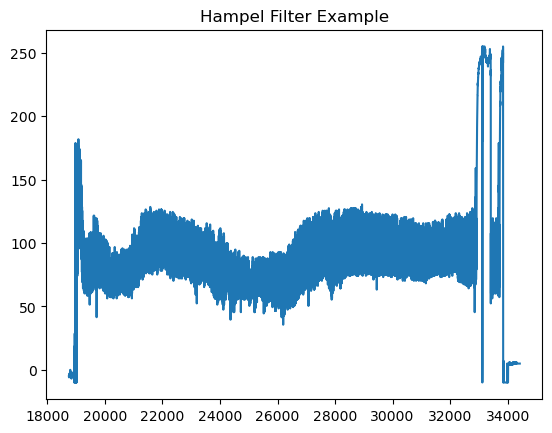

In [60]:
cleaned_ts.plot(title="Hampel Filter Example")

In [71]:
import vitaldb
from tqdm import tqdm

In [72]:
features = ["ART", "ECG_II", "PLETH", "CO2", "PHEN_RATE"]
cases = vitaldb.find_cases(features)
print("Number of cases found:", len(cases))

values_for_all_cases = {}
for case in tqdm(cases):
    vals = vitaldb.load_case(case, features, interval=1)
    values_for_all_cases[case] = vals

rows = []
for case_id, arr in values_for_all_cases.items():
    # arr should be ordered in time; enumerate will give 1,2,3,... per case
    for t_idx, row in enumerate(arr, start=1):
        rows.append([case_id, t_idx] + list(row))

# DataFrame with time per id
df = pd.DataFrame(rows, columns=["id", "time"] + features)

# Ensure sorted by id,time and reset index
df = df.sort_values(["id", "time"]).reset_index(drop=True)

Number of cases found: 103


100%|██████████| 103/103 [12:26<00:00,  7.25s/it]


In [75]:
df[df["id"] == ids[2]]

,id,time,ART,ECG_II,PLETH,CO2,PHEN_RATE
1155166,4618,1,NaN,NaN,NaN,0.0,NaN
1155167,4618,2,NaN,NaN,NaN,0.0,NaN
1155168,4618,3,NaN,NaN,NaN,0.0,NaN
1155169,4618,4,NaN,NaN,NaN,0.0,NaN
1155170,4618,5,-4.85986,-0.334961,1.21592,0.0,NaN
...,...,...,...,...,...,...,...
1170833,4618,15668,5.01471,0.050147,1.61090,0.9,NaN
1170834,4618,15669,6.00217,0.060022,1.61090,0.9,NaN
1170835,4618,15670,5.01471,0.050147,1.61090,0.9,NaN
1170836,4618,15671,5.01471,0.050147,1.61090,1.0,NaN
